In [1]:
import re
import glob
import pandas as pd
import nibabel as nb
import numpy as np
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting

/data/softwares/anaconda3/2019.10/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# importing rmaps

In [2]:
network_interest = "DMN"
connectivity_maps = glob.glob("rest/rmap_seeds/*sub*_"+network_interest+".nii.gz")
len(connectivity_maps)

112

# import csv file 

In [3]:
#load the csv files
cimaq_diagnostic = pd.read_csv('36448_diagnostic_clinique.tsv', sep = '\t')
cimaq_diagnostic.head()

,PSCID,CandID,Candidate_Age,Data_entry_completion_status,Validity,Visit_stage,36448_diagnostic_clinique,36448_diagnostic_clinique_detail,36448_diagnostic_clinique_detail_status,36448_eligible_cimaq,36448_medecin_specialite
0,8212673,914042.0,75.7,Complete,Valid,Approval,trouble_cognitif_léger_précoce,"Plainte cognitive objective (mnésique, languag...",NaN,oui,gériatre
1,7853010,414656.0,69.7,Complete,Valid,Approval,trouble_cognitif_léger_précoce,"Plainte mnésique, discrètes difficultés d'orga...",NaN,oui,gériatre
2,7112485,866678.0,82.1,Complete,Valid,Approval,trouble_cognitif_léger_précoce,"Légers troubles exécutifs, attentionnels, d'ab...",NaN,oui,gériatre
3,6051205,878652.0,78.6,Complete,Valid,Approval,démence_de_type_alzheimer-légère,Pas de notes manuscrites.,NaN,oui,gériatre
4,4932877,318809.0,70.9,Complete,Valid,Approval,cognitivement_sain_(cs),NaN,donnée_non_disponible,oui,gériatre


In [4]:
print(set(cimaq_diagnostic['36448_diagnostic_clinique'].values))

#Rename the columns
cimaq_diagnostic = cimaq_diagnostic[["PSCID",'CandID','36448_diagnostic_clinique','Candidate_Age']]
cimaq_diagnostic.rename(columns = {"CandID":"subID","36448_diagnostic_clinique":"diagnostic","Candidate Age":"Age" },inplace=True)

#drop the rows that have nan
cimaq_diagnostic.dropna(inplace=True)

#drop the subjects that have AD
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "démence_de_type_alzheimer-légère" ]

#Get the subject IDs from the the rmaps
subjectID_set = set([sub.split("sub")[1].split("_")[0] for sub in connectivity_maps])
                    
#drop the subjects from csv if rmaps are not present
cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]                   
                    
print(cimaq_diagnostic.shape)
cimaq_diagnostic.head()

{nan, 'cognitivement_sain_(cs)', 'troubles_subjectifs_de_cognition', 'démence_de_type_alzheimer-légère', 'trouble_cognitif_léger_précoce', 'trouble_cognitif_léger_tardif'}
(99, 4)


,PSCID,subID,diagnostic,Candidate_Age
4,4932877,318809.0,cognitivement_sain_(cs),70.9
9,8734231,651050.0,trouble_cognitif_léger_tardif,81.1
11,8875385,437101.0,cognitivement_sain_(cs),74.5
12,8697622,324734.0,cognitivement_sain_(cs),89.3
21,3431566,164965.0,cognitivement_sain_(cs),66.3


In [5]:
scd_csv = pd.read_excel('scd_cimaq.xlsx')
scd_plus = scd_csv.loc[scd_csv["Diagnostic_SCD_MCI"] == 22]["ID"].values
scd_minus = scd_csv.loc[scd_csv["Diagnostic_SCD_MCI"] == 2]["ID"].values
# scd_plus
# scd_csv

In [6]:
print(len(scd_plus))
print(len(scd_minus))

26
41


# create design matrix

In [7]:

cimaq_diagnostic["MCI"] = 0
cimaq_diagnostic["SCD"] = 0
cimaq_diagnostic["CN"] = 0

for i,r in cimaq_diagnostic.iterrows():
    
#     if(r["diagnostic"] == "troubles_subjectifs_de_cognition" ):
#         cimaq_diagnostic.loc[i,"SCD"] = 1

    if(r["diagnostic"] == "cognitivement_sain_(cs)" or r["PSCID"] in scd_minus):
        cimaq_diagnostic.loc[i,"CN"] = 1          

    if("trouble_cognitif_léger" in r["diagnostic"] or  r["PSCID"] in scd_plus):
        cimaq_diagnostic.loc[i,"MCI"] = 1


    cimaq_diagnostic.loc[i,"subID"] = str(r["subID"]).split(".")[0]
    

# cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["diagnostic"] != "démence_de_type_alzheimer-légère" ]
# cimaq_diagnostic = cimaq_diagnostic.loc[cimaq_diagnostic["subID"].isin(subjectID_set)]
cimaq_diagnostic.head()

/data/softwares/anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]
/data/softwares/anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


,PSCID,subID,diagnostic,Candidate_Age,MCI,SCD,CN
4,4932877,318809,cognitivement_sain_(cs),70.9,0,0,1
9,8734231,651050,trouble_cognitif_léger_tardif,81.1,1,0,0
11,8875385,437101,cognitivement_sain_(cs),74.5,0,0,1
12,8697622,324734,cognitivement_sain_(cs),89.3,0,0,1
21,3431566,164965,cognitivement_sain_(cs),66.3,0,0,1


In [8]:
np.sum(cimaq_diagnostic["SCD"].values)

0

In [9]:
design_matrix = cimaq_diagnostic[["MCI","CN"]]
design_matrix.shape

(99, 2)

# perform  t-test

In [10]:
#take the rmaps that are in the csv
second_level_input = []
for i in connectivity_maps:
    sub = re.search("\d\d\d\d\d\d",i)
    subid = sub.group(0)
    if(subid in set(cimaq_diagnostic["subID"].values)):        
        second_level_input.append(i)


In [11]:
second_level_model = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
z_score = second_level_model.compute_contrast(second_level_contrast = [1,-1])

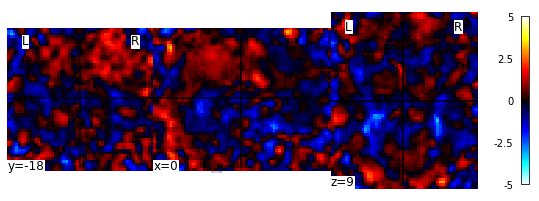

In [14]:
plotting.plot_stat_map(z_score)

/home/hanads/.local/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


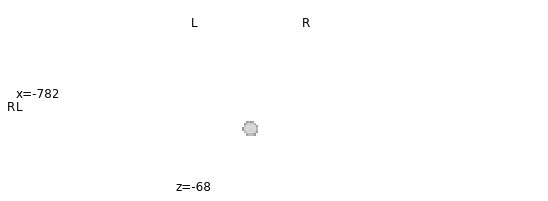

In [15]:
thresholded_map, threshold = map_threshold(z_score, alpha=0.1, height_control='fdr')
plotting.plot_stat_map(thresholded_map)

# F-test

In [ ]:
second_level_model2 = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
p_map = second_level_model2.compute_contrast(second_level_contrast = [1,1,1], second_level_stat_type = "F")

In [ ]:
plotting.view_img(p_map)